# COVID-19 and Population project

In this project I am evaluating the Coronavitus data in order to answer some questions like:

**1. Which is the most related variable to COVID-19 Cases?**

**2. Is COVID-19 related to the age?**

**3. Are the countries with some kind of free Healthcare policies more affected than the rest?**

## 1. Gather the data
The first step is call the libraries and get the dataset:


In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapefile as shp
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import geopandas as gpd
%matplotlib inline

#I get the df from website worldometers.info

url_popu = 'https://www.worldometers.info/world-population/population-by-country/'
url_covid = 'https://www.worldometers.info/coronavirus/#countries'
#url that I used for downloading the data
r_popu = requests.get(url_popu)
r_covid = requests.get(url_covid)
soup_popu = BeautifulSoup(r_popu.content)
soup_covid = BeautifulSoup(r_covid.content)
countries_popu = soup_popu.find_all('table')[0]
countries_covid = soup_covid.find_all('table')[0]
df_popu = pd.read_html(str(countries_popu))[0]
df_covid = pd.read_html(str(countries_covid))[0]

#Also I get a healthcare from a csv file, a list of countries with free Healtcare policies
df_healthcare = pd.read_csv('countries with free healthcare.csv')

### 1.1. First visualization

You can see below the heads of the created **DataFrames**

In [2]:
df_popu.head()

,#,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,1,China,1439323776,0.39 %,5540090,153,9388211,-348399.0,1.7,38,61 %,18.47 %
1,2,India,1380004385,0.99 %,13586631,464,2973190,-532687.0,2.2,28,35 %,17.70 %
2,3,United States,331002651,0.59 %,1937734,36,9147420,954806.0,1.8,38,83 %,4.25 %
3,4,Indonesia,273523615,1.07 %,2898047,151,1811570,-98955.0,2.3,30,56 %,3.51 %
4,5,Pakistan,220892340,2.00 %,4327022,287,770880,-233379.0,3.6,23,35 %,2.83 %


In [3]:
df_covid.head()


,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/ 1M pop
0,World,3451594,"+53,500",243004.0,"+3,556",1102551.0,2106039,50934.0,443.0,31.2,NaN,NaN
1,USA,1142775,"+11,745",66621.0,+868,162107.0,914047,16481.0,3452.0,201.0,6802653.0,20552.0
2,Spain,245567,"+2,588",25100.0,+276,146233.0,74234,2386.0,5252.0,537.0,1528833.0,32699.0
3,Italy,209328,"+1,900",28710.0,+474,79914.0,100704,1539.0,3462.0,475.0,2108837.0,34879.0
4,UK,182260,"+4,806",28131.0,+621,NaN,153785,1559.0,2685.0,414.0,1129907.0,16644.0


I want to change some columns names:

In [4]:
df_covid.rename(columns={"TotalCases": "Total_Cases",
                   "TotalDeaths": "Total_Deaths", 
                  'TotalRecovered': 'Total_Recovered',
                  'TotalTests': 'Total_Tests'}, inplace=True)

In [5]:
df_healthcare.head()

,name,pop2020
0,Albania,2877.797
1,Algeria,43851.044
2,Andorra,77.265
3,Antigua and Barbuda,97.929
4,Argentina,45195.774


### 1.2. Creating a new dataframe

I will use a new DataFrame based in the Population one. I will call it **df_raw**

In [6]:
#I get the columns that I want to use from df_popu

df_raw = pd.DataFrame()
df_raw['Country'] = df_popu['Country (or dependency)']
df_raw['Population'] = df_popu['Population (2020)']
df_raw['People_per_sqKm'] = df_popu['Density (P/Km²)']
df_raw['Migrants'] = df_popu['Migrants (net)']
df_raw['Avg_Age'] = df_popu['Med. Age']
df_raw['Urban_Pop_perc'] = df_popu['Urban Pop %']

df_raw.head()

,Country,Population,People_per_sqKm,Migrants,Avg_Age,Urban_Pop_perc
0,China,1439323776,153,-348399.0,38,61 %
1,India,1380004385,464,-532687.0,28,35 %
2,United States,331002651,36,954806.0,38,83 %
3,Indonesia,273523615,151,-98955.0,30,56 %
4,Pakistan,220892340,287,-233379.0,23,35 %


### 1.3. Joining Dataframes

I am going to **join** df_raw with the Covid-19 data and Healthcare data.
All have the countries in common, although the spelling is not the same. I have created two **dictionaries** to make a match for all the countries.

In [7]:

covid_dic = {'USA':'United States', 'UK':'United Kingdom', 'S. Korea':'South Korea', 'UAE':'United Arab Emirates',
               'Czechia':'Czech Republic (Czechia)', 'Ivory Coast':"Côte d'Ivoire", 'DRC':'DR Congo',
               'Palestine':'State of Palestine', 'CAR':'Central African Republic', 'Saint Kitts and Nevis':'Saint Kitts & Nevis',
               'St. Vincent Grenadines':'St. Vincent & Grenadines', 'Vatican City':'Holy See', 'St. Barth':'Saint Barthelemy',
               'Sao Tome and Principe':'Sao Tome & Principe', 'Saint Pierre Miquelon':'Saint Pierre & Miquelon'}

df_covid.replace({'Country,Other': covid_dic},  inplace = True)


healthcare_dic = {'Czech Republic':'Czech Republic (Czechia)',
           'Macau':'Macao',
           'Saint Vincent and the Grenadines':'St. Vincent & Grenadines'}

df_healthcare.replace({'name': healthcare_dic},  inplace = True)


In [8]:
df_covid.head()


,"Country,Other",Total_Cases,NewCases,Total_Deaths,NewDeaths,Total_Recovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,Total_Tests,Tests/ 1M pop
0,World,3451594,"+53,500",243004.0,"+3,556",1102551.0,2106039,50934.0,443.0,31.2,NaN,NaN
1,United States,1142775,"+11,745",66621.0,+868,162107.0,914047,16481.0,3452.0,201.0,6802653.0,20552.0
2,Spain,245567,"+2,588",25100.0,+276,146233.0,74234,2386.0,5252.0,537.0,1528833.0,32699.0
3,Italy,209328,"+1,900",28710.0,+474,79914.0,100704,1539.0,3462.0,475.0,2108837.0,34879.0
4,United Kingdom,182260,"+4,806",28131.0,+621,NaN,153785,1559.0,2685.0,414.0,1129907.0,16644.0


In [9]:
df_healthcare.head()

,name,pop2020
0,Albania,2877.797
1,Algeria,43851.044
2,Andorra,77.265
3,Antigua and Barbuda,97.929
4,Argentina,45195.774


Now **columns**:  "Country", "Country,Other" and "name" from df_raw, df_covid and df_healtcare has the countries with the same spelling.

Prior to the **join** lets remove some columns that I do not want to evaluate. Also I will create a column in df_healthcare with 1 as the value.

That will make easier the join, you will see the Free_healthcare column with values **"1"** upon countries with Free healthcare policies and **NaN** values on the rest, I will change NaN to 0 later on


In [10]:
#I remove the columns from df_covid that I am not interested in 
df_covid = df_covid.drop(['NewCases','NewDeaths','ActiveCases','Serious,Critical',df_covid.columns[8],'Tests/ 1M pop','Deaths/1M pop'],axis=1)
df_healthcare['Free_healthcare'] = 1 #I create a column in healthcar with 1 as the value
df_healthcare.drop(['pop2020'], axis=1, inplace=True)

In [11]:
df_covid.head()

,"Country,Other",Total_Cases,Total_Deaths,Total_Recovered,Total_Tests
0,World,3451594,243004.0,1102551.0,NaN
1,United States,1142775,66621.0,162107.0,6802653.0
2,Spain,245567,25100.0,146233.0,1528833.0
3,Italy,209328,28710.0,79914.0,2108837.0
4,United Kingdom,182260,28131.0,NaN,1129907.0


In [12]:
df_healthcare.head()

,name,Free_healthcare
0,Albania,1
1,Algeria,1
2,Andorra,1
3,Antigua and Barbuda,1
4,Argentina,1


#### Finally the Join

In [13]:
#I join both tables using as index the country
df_raw = df_raw.join(df_healthcare.set_index('name'), on='Country')
df_raw = df_raw.join(df_covid.set_index('Country,Other'), on='Country')

df_raw.head()

,Country,Population,People_per_sqKm,Migrants,Avg_Age,Urban_Pop_perc,Free_healthcare,Total_Cases,Total_Deaths,Total_Recovered,Total_Tests
0,China,1439323776,153,-348399.0,38,61 %,1.0,82875.0,4633.0,77685.0,NaN
1,India,1380004385,464,-532687.0,28,35 %,NaN,37776.0,1223.0,10007.0,976363.0
2,United States,331002651,36,954806.0,38,83 %,NaN,1142775.0,66621.0,162107.0,6802653.0
3,Indonesia,273523615,151,-98955.0,30,56 %,NaN,10843.0,831.0,1665.0,107943.0
4,Pakistan,220892340,287,-233379.0,23,35 %,1.0,18770.0,432.0,4753.0,193859.0


### 2. Assess

Well before clean and analyze the figures, lets understand which kind of data we have:

In [14]:
df_raw.dtypes

Country             object
Population           int64
People_per_sqKm      int64
Migrants           float64
Avg_Age             object
Urban_Pop_perc      object
Free_healthcare    float64
Total_Cases        float64
Total_Deaths       float64
Total_Recovered    float64
Total_Tests        float64
dtype: object

It seems that most of our variables are numbers! that is good to evaluate the dataframe, however we shall understand the Free Healthcare as a Categorical value:

   **1** means "yes", with Free Healthcare policies
   
   **NaN** means the contrary (we will change it later to "0")
    
In any case we have 2 objects types: Avg_Age and Urban_Pop and Country.
Country will be maintain here, but will be removed later for the evaluation of the model, I do not care about the countries, just about the figures, and we have a single figure for each country.

For the rest of the **objects**, those are **not categorical vales**, should be **numerical**. Lets find out why and change it to numbers.

### 2.1. Checking the objects

In [15]:
df_raw['Avg_Age'].unique()#looking for the value that make the column an object

array(['38', '28', '30', '23', '33', '18', '40', '29', '48', '19', '26',
       '25', '32', '17', '46', '42', '47', '20', '44', '31', '45', '41',
       '21', '22', '35', '15', '34', '16', '43', '24', '27', '37', '36',
       '39', 'N.A.'], dtype=object)

In [16]:
df_raw['Urban_Pop_perc'].unique()#looking for the value that make the column an object

array(['61 %', '35 %', '83 %', '56 %', '88 %', '52 %', '39 %', '74 %',
       '84 %', '92 %', '21 %', '47 %', '43 %', '38 %', '46 %', '76 %',
       '51 %', '82 %', '69 %', '37 %', '67 %', '31 %', '28 %', '80 %',
       '26 %', '93 %', '73 %', '25 %', '60 %', '81 %', '64 %', '50 %',
       '79 %', '78 %', '57 %', 'N.A.', '63 %', '86 %', '17 %', '18 %',
       '44 %', '55 %', '85 %', '58 %', '45 %', '49 %', '24 %', '23 %',
       '48 %', '14 %', '70 %', '98 %', '91 %', '66 %', '72 %', '27 %',
       '13 %', '36 %', '62 %', '53 %', '54 %', '87 %', '68 %', '96 %',
       '71 %', '59 %', '89 %', '33 %', '41 %', '30 %', '100 %', '29 %',
       '65 %', '94 %', '19 %', '95 %', '97 %', '0 %', '15 %', '75 %',
       '10 %'], dtype=object)

It seems that the problem is **N.A.** and **%**.

Firstly, I will replace chr **'%'** and then, I will use pandas **tonumeric** to change the type

In [17]:
df_raw['Urban_Pop_perc'] = [perc.replace(' %','') for perc in df_raw['Urban_Pop_perc']]

In [18]:
df_raw['Avg_Age'] = pd.to_numeric(df_raw['Avg_Age'],errors='coerce')
df_raw['Urban_Pop_perc'] = pd.to_numeric(df_raw['Urban_Pop_perc'],errors='coerce')/100

In [19]:
df_raw.head()

,Country,Population,People_per_sqKm,Migrants,Avg_Age,Urban_Pop_perc,Free_healthcare,Total_Cases,Total_Deaths,Total_Recovered,Total_Tests
0,China,1439323776,153,-348399.0,38.0,0.61,1.0,82875.0,4633.0,77685.0,NaN
1,India,1380004385,464,-532687.0,28.0,0.35,NaN,37776.0,1223.0,10007.0,976363.0
2,United States,331002651,36,954806.0,38.0,0.83,NaN,1142775.0,66621.0,162107.0,6802653.0
3,Indonesia,273523615,151,-98955.0,30.0,0.56,NaN,10843.0,831.0,1665.0,107943.0
4,Pakistan,220892340,287,-233379.0,23.0,0.35,1.0,18770.0,432.0,4753.0,193859.0


In [20]:
df_raw.dtypes

Country             object
Population           int64
People_per_sqKm      int64
Migrants           float64
Avg_Age            float64
Urban_Pop_perc     float64
Free_healthcare    float64
Total_Cases        float64
Total_Deaths       float64
Total_Recovered    float64
Total_Tests        float64
dtype: object

Finally I will create a column with the index, named **Country_Id**, to keep the traceability of the data, since later on I will remove Country column. Also I will keep a dictionary to save its relationship


## 3. Clean and analyze the model

Now  I create a function that cleans the DF, create the model and gives back:

**1.** The r squared value to know if the model is ok to predict cases

**2.** The effect grade

**3.** The coefficients of the model

In my case the X will be always the population and Healthcare columns. Regarding the 'y', I will check all the columns from COVID: total cases, total deaths, total recovered and total tests.


#### Function

To understand the cleaning, let's see the proportion of **NaN** values in each column:

In [21]:
df_raw.isnull().mean()

Country            0.000000
Population         0.000000
People_per_sqKm    0.000000
Migrants           0.144681
Avg_Age            0.144681
Urban_Pop_perc     0.055319
Free_healthcare    0.523404
Total_Cases        0.097872
Total_Deaths       0.263830
Total_Recovered    0.131915
Total_Tests        0.238298
dtype: float64

In [22]:
df_raw['Free_healthcare'].fillna(0, inplace=True)
#As I mentioned in 1.3, NaN values of this column are changed to 0 (representing NO) 

In [23]:
def get_model_inf(df, resp):
    '''
    INPUT
    df - pandas dataframe 
    resp - column name for the y
    
    OUTPUT
    rsquared value
    effect of the rsquared 
    dataframe of the model coefficients
    '''
    #first we remove the 'Country' column, which does not add value to our model
    df = df.drop(['Country'],axis=1)
    
    #then I drop the columns that I do not want to use depending on which is the response vector
    if resp == 'Total_Cases':
        df = df.drop(['Total_Deaths','Total_Recovered', 'Total_Tests'],axis=1)
    elif resp == 'Total_Deaths':
        df = df.drop(['Total_Cases','Total_Recovered','Total_Tests'],axis=1)
    elif resp == 'Total_Recovered':
        df = df.drop(['Total_Cases','Total_Deaths','Total_Tests'],axis=1)
    elif resp == 'Total_Tests':
        df = df.drop(['Total_Cases','Total_Deaths','Total_Recovered'],axis=1)
        df['Total_Tests'].fillna(0, inplace=True)#I assume that, if there are no figures for test, country is not doing test
    else:
        print('error, no right input')
    
    #I remove any NaN
    df = df.dropna(subset=[resp], axis=0)
    #Below I remove the NaN with the average of each column
    df['Avg_Age'].fillna((df['Avg_Age'].mean()), inplace=True)
    df['Urban_Pop_perc'].fillna((df['Urban_Pop_perc'].mean()), inplace=True)
    df['Migrants'].fillna((df['Migrants'].mean()), inplace=True)
    #I create the X matrix and the y response vector
    y = df[resp]
    df = df.drop([resp], axis=1)
    X = df
    #Rsquared and y_test
    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X, y) #Fit
    y_preds = lm_model.predict(X)
    rsquared_score = r2_score(y, y_preds)
    
    if rsquared_score<0.3:
        effect = 'very weak'
    elif rsquared_score<0.5:
        effect = 'weak'
    elif rsquared_score<0.7:
        effect = 'moderate'
    else:
        effect = 'strong'
    #here I get the coefficients
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return rsquared_score, effect, coefs_df

#### Analyzing the model

In [24]:
#4 possible evaluations, TotalCases, TotalDeaths and TotalRecovered
resp_cases = ['Total_Cases','Total_Deaths','Total_Recovered','Total_Tests']
for case in resp_cases:
    rsquared_score, effect, coefs_df = get_model_inf(df_raw,case)
    print("With {} as vector response: The rsquared is {}.".format(case.replace('_',' '),rsquared_score))
    print('Such rsquared value means that the effect is {}.\n'.format(effect))
    print('Its coefficients dataframe is:\n\t')
    print(coefs_df)

With Total Cases as vector response: The rsquared is 0.5361767399372764.
Such rsquared value means that the effect is moderate.

Its coefficients dataframe is:
	
           est_int         coefs     abs_coefs
5  Free_healthcare -10948.205088  10948.205088
4   Urban_Pop_perc  -3179.419313   3179.419313
3          Avg_Age    684.608558    684.608558
2         Migrants      0.505622      0.505622
1  People_per_sqKm     -0.502235      0.502235
0       Population      0.000247      0.000247
With Total Deaths as vector response: The rsquared is 0.4285166072512825.
Such rsquared value means that the effect is weak.

Its coefficients dataframe is:
	
           est_int       coefs   abs_coefs
5  Free_healthcare -931.691997  931.691997
4   Urban_Pop_perc  -95.283578   95.283578
3          Avg_Age   88.258884   88.258884
1  People_per_sqKm   -0.061440    0.061440
2         Migrants    0.031106    0.031106
0       Population    0.000014    0.000014
With Total Recovered as vector response: The rsqu

#### Moderate

is the relation between COVID-19 cases and the matrix evaluated.
Let see which is  the actual relationship between all of them in some **insights**.

But, firstly, since **TOTAL CASES** is the best represented column, I am going to clean df_raw and clean the NaN

In [25]:
df_plot = df_raw.copy()
df_plot = df_plot.dropna(subset=['Total_Cases'], axis=0)
#Below I remove the NaN with a "0"
df_plot['Total_Deaths'].fillna(0, inplace=True)
df_plot['Total_Recovered'].fillna(0, inplace=True)
#df_plot['Total_Tests'].fillna(0, inplace=True)
#Below I remove the NaN with the average of each column
df_plot['Avg_Age'].fillna((df_plot['Avg_Age'].mean()), inplace=True)
df_plot['Urban_Pop_perc'].fillna((df_plot['Urban_Pop_perc'].mean()), inplace=True)
df_plot['Migrants'].fillna((df_plot['Migrants'].mean()), inplace=True)
df_plot.isnull().mean()

Country            0.00000
Population         0.00000
People_per_sqKm    0.00000
Migrants           0.00000
Avg_Age            0.00000
Urban_Pop_perc     0.00000
Free_healthcare    0.00000
Total_Cases        0.00000
Total_Deaths       0.00000
Total_Recovered    0.00000
Total_Tests        0.15566
dtype: float64

In [26]:
df_plot.head()

,Country,Population,People_per_sqKm,Migrants,Avg_Age,Urban_Pop_perc,Free_healthcare,Total_Cases,Total_Deaths,Total_Recovered,Total_Tests
0,China,1439323776,153,-348399.0,38.0,0.61,1.0,82875.0,4633.0,77685.0,NaN
1,India,1380004385,464,-532687.0,28.0,0.35,0.0,37776.0,1223.0,10007.0,976363.0
2,United States,331002651,36,954806.0,38.0,0.83,0.0,1142775.0,66621.0,162107.0,6802653.0
3,Indonesia,273523615,151,-98955.0,30.0,0.56,0.0,10843.0,831.0,1665.0,107943.0
4,Pakistan,220892340,287,-233379.0,23.0,0.35,1.0,18770.0,432.0,4753.0,193859.0


## 4.Visualization and evaluation of the insights

  I am going to prove to see what says an histogram for the new df_plot

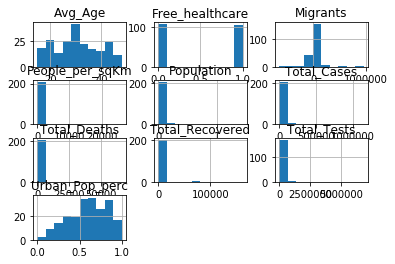

In [27]:
df_plot.hist();

Above histogrand does not tell me much to me, let see a heatmap:

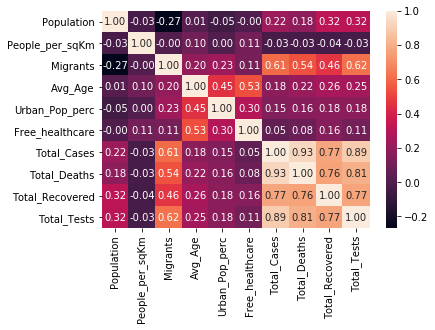

In [28]:
sns.heatmap(df_plot.corr(), annot= True, fmt='.2f');

It seems quite better, I can see a high correlation with Migrants, let see it with a higher detail.

In [29]:
df_corr = df_plot.corr()
df_corr = df_corr[['People_per_sqKm','Migrants','Avg_Age','Urban_Pop_perc','Free_healthcare']]
df_corr = df_corr.drop(['Population','People_per_sqKm','Migrants','Avg_Age','Urban_Pop_perc','Free_healthcare'],axis=0)
df_corr

,People_per_sqKm,Migrants,Avg_Age,Urban_Pop_perc,Free_healthcare
Total_Cases,-0.027220,0.608307,0.179809,0.149497,0.049443
Total_Deaths,-0.029500,0.543078,0.215673,0.163828,0.079747
Total_Recovered,-0.037923,0.464196,0.258895,0.176057,0.161134
Total_Tests,-0.034256,0.621568,0.251592,0.181564,0.106051


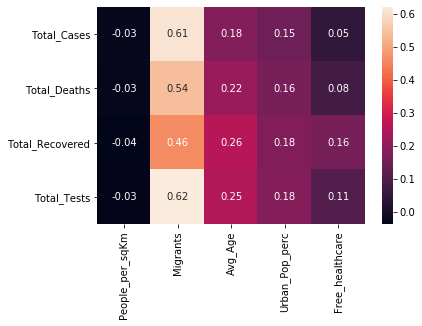

In [30]:
sns.heatmap(df_corr, annot= True, fmt='.2f');


In [31]:
plt.savefig('heatmap_01.png')#I like the pic and I save it

<Figure size 432x288 with 0 Axes>

### First question answered

**Migrants** is the column with a higher correlation with the COVID-19 cases, I was expecting People per square Kilometer, but it is not related at all! actually it have negative relationship.

I want to plot the scatter of the columns with a higher relationship, TOTAL CASES and MIGRANTS. to double check its relationship.


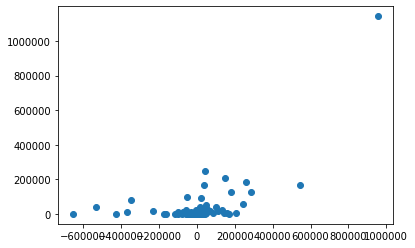

In [32]:

plt.scatter(df_plot['Migrants'],df_plot['Total_Cases'])

plt.show()

Let see the **linear regression** in the plot. I am going to create functions to make life easier

In [33]:
from scipy import stats


In [34]:
def plot_lin(x,y):
    slope, intercept, r, p, std_err = stats.linregress(x, y)
    mymodel = list(map(lambda x: slope * x + intercept, x))
    plt.scatter(x, y)
    plt.plot(x, mymodel)
    return plt, r

In [35]:
def plot_poly(x,y,mini,maxi,grade):
    mymodel = np.poly1d(np.polyfit(x, y, grade))
    myline = np.linspace(mini, maxi, 100)
    plt.scatter(x, y)
    plt.plot(myline, mymodel(myline))
    r = r2_score(y, mymodel(x))
    return plt, r

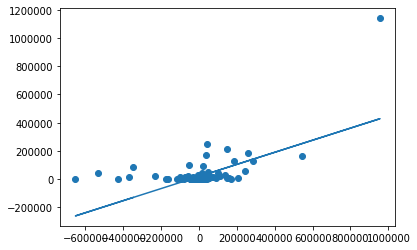

In [36]:
plt, r = plot_lin(df_plot['Migrants'],df_plot['Total_Cases'])

plt.show() 

In [37]:
r#check the r2

0.6083067009619647

It seems that a polynomial regression will match much better:

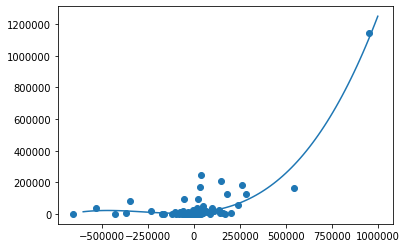

In [38]:
plt, r = plot_poly(df_plot['Migrants'],df_plot['Total_Cases'],-600000,1000000,3)
plt.show()


In [39]:
r#check the r2

0.8755671249983175

#### GREAT

I have got a curve that represents the relation between them in a right way.

Now, I will plotter the Average age


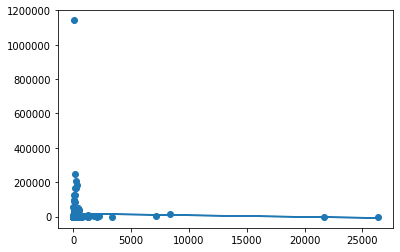

In [40]:
plt, r = plot_lin(df_plot['People_per_sqKm'],df_plot['Total_Cases'])

plt.show() 

Chart above does not show much

### What about Average  Age?

let see if we can find a model to relate average age with deaths.

0.21567308622563236

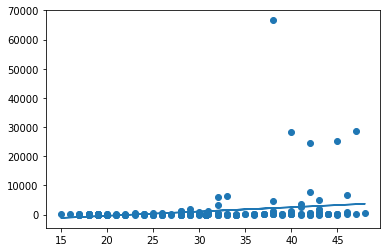

In [41]:
plt, r = plot_lin(df_plot['Avg_Age'],df_plot['Total_Deaths'])
r

In [42]:
r

0.21567308622563236

0.25889454222139086

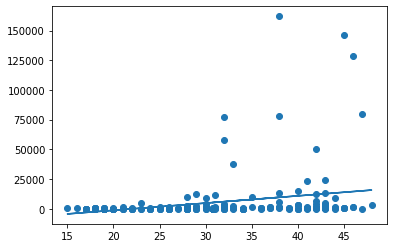

In [43]:
plt, r = plot_lin(df_plot['Avg_Age'],df_plot['Total_Recovered'])
r

C:\Users\cvila\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\cvila\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\cvila\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


nan

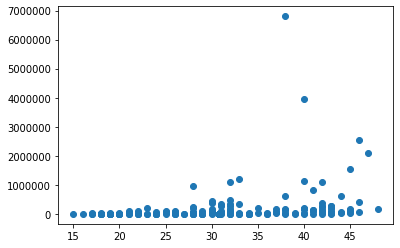

In [44]:
plt, r = plot_lin(df_plot['Avg_Age'],df_plot['Total_Tests'])
r

I cannot see a good **model** matching with the figures. However it is clear that the higher is the average age, the higher are the Deaths. However the relationship is even higher with the recoverd cases and with the tests made in the country

Lets plot another heatmap to show Average Age correlation with population columns as well.



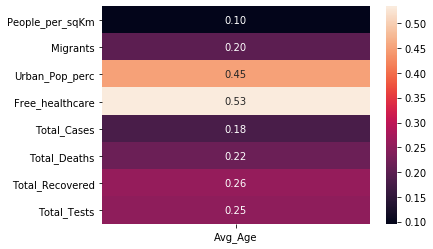

In [45]:
df_age_corr = df_plot.corr()
df_age_corr_plot = df_age_corr.loc[['People_per_sqKm','Migrants','Urban_Pop_perc','Free_healthcare',
                                    'Total_Cases','Total_Deaths','Total_Recovered','Total_Tests'],['Avg_Age']]
sns.heatmap(df_age_corr_plot, annot= True, fmt='.2f');

In [46]:
plt.savefig('heatmap_02.png')#I like the pic and I save it

<Figure size 432x288 with 0 Axes>

It is clear that the **average age** is directly related with **Free Healthcare**. I mean in the countries with Free Healthcare policies, the average age seems to be higher

### Healthcare

Lets plot some good **insights** to see its relationship.

I am going to prepare a table with the Cases Fatality rate, Test per million, etc.

In [47]:

df_plot.head()


,Country,Population,People_per_sqKm,Migrants,Avg_Age,Urban_Pop_perc,Free_healthcare,Total_Cases,Total_Deaths,Total_Recovered,Total_Tests
0,China,1439323776,153,-348399.0,38.0,0.61,1.0,82875.0,4633.0,77685.0,NaN
1,India,1380004385,464,-532687.0,28.0,0.35,0.0,37776.0,1223.0,10007.0,976363.0
2,United States,331002651,36,954806.0,38.0,0.83,0.0,1142775.0,66621.0,162107.0,6802653.0
3,Indonesia,273523615,151,-98955.0,30.0,0.56,0.0,10843.0,831.0,1665.0,107943.0
4,Pakistan,220892340,287,-233379.0,23.0,0.35,1.0,18770.0,432.0,4753.0,193859.0


In [48]:
df_hc = pd.DataFrame()

In [49]:
df_hc['Free_Healthcare'] = df_plot['Free_healthcare']
dic_fh = {1: 'Yes', 0:'No'}#dictionary to change 1 and 0 to the right categorical value
df_hc.replace({'Free_Healthcare':dic_fh}, inplace = True)
df_hc['Population'] = df_plot['Population']
group_df_hc_raw = df_hc.groupby('Free_Healthcare').agg({'count','sum'})
group_df_hc_raw

Population            
                     count         sum
Free_Healthcare                       
No                     107  3928832487
Yes                    105  3827096811

### Rough figures

Above table is nice, you can see quickly how many countries has free healtcare policies and the amount of people.
Let's edit the fortmats:

In [50]:
df_hc_table = pd.DataFrame()
df_hc_table['Free Healthcare Policies'] = group_df_hc_raw.index
df_hc_table['Number of Countries'] = group_df_hc_raw[('Population', 'count')].tolist()
df_hc_table['People in the group'] = group_df_hc_raw[('Population','sum')].apply(lambda x: "{0:.2f} Billions".format(x/1e9)).tolist()
df_hc_table

,Free Healthcare Policies,Number of Countries,People in the group
0,No,107,3.93 Billions
1,Yes,105,3.83 Billions


Creating a couple of function to save time if I want to get rates grouped by or not:

In [51]:
def group_df(df,gr_by = None):
    x = [gr_by, 'Population']
    if gr_by != None:
        df = df.drop(list(set(df.columns.tolist()[0:7]) - set(x)),axis=1)
        df = df.groupby(gr_by).sum()
        
    return df

def rate_df(df, clean=False):
    df['Cases per 1M P']= (df['Total_Cases']*1e6)/df['Population']
    df['Tests per 1M P']= (df['Total_Tests']*1e6)/df['Population']
    df['Deaths per 1M P'] = (df['Total_Deaths']*1e6)/df['Population']
    df['Recovered per 1M P'] = (df['Total_Recovered']*1e6)/df['Population']
    df['Total_Tests'].mask(df['Total_Tests']<df['Total_Cases'],df['Total_Cases'],inplace=True)
    df['Positives Rate']= df['Total_Cases']*100/df['Total_Tests']
    df['Case Fatality Rate'] = (df['Total_Deaths']*100)/df['Total_Cases']
    df['Case Recovery Rate'] = (df['Total_Recovered']*100)/df['Total_Cases']
    df['Active Cases Rate'] = 100 - (df['Case Fatality Rate'] + df['Case Recovery Rate'])
    if clean == True:
        df = df.drop(df.columns.tolist()[0:5],axis=1)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)#in positives rate np.inf might happen
    return df



Now I am going to get higher details, rates and so on:

In [52]:
group_df_hc = pd.DataFrame()
group_df_hc = group_df(df_plot,'Free_healthcare')
group_df_hc.head()

,Population,Total_Cases,Total_Deaths,Total_Recovered,Total_Tests
Free_healthcare,,,,,
0.0,3928832487,1298466.0,73063.0,209576.0,9935226.0
1.0,3827096811,2152407.0,169926.0,891736.0,26231946.0


In [53]:
group_df_hc = rate_df(group_df_hc)
group_df_hc.head()

,Population,Total_Cases,Total_Deaths,Total_Recovered,Total_Tests,Cases per 1M P,Tests per 1M P,Deaths per 1M P,Recovered per 1M P,Positives Rate,Case Fatality Rate,Case Recovery Rate,Active Cases Rate
Free_healthcare,,,,,,,,,,,,,
0.0,3928832487,1298466.0,73063.0,209576.0,9935226.0,330.496656,2528.798576,18.596619,53.343073,13.069315,5.626870,16.140276,78.232853
1.0,3827096811,2152407.0,169926.0,891736.0,26231946.0,562.412478,6854.267685,44.400758,233.005864,8.205289,7.894696,41.429711,50.675592


In [54]:
group_df_hc = rate_df(group_df_hc,True)
group_df_hc.head()

,Cases per 1M P,Tests per 1M P,Deaths per 1M P,Recovered per 1M P,Positives Rate,Case Fatality Rate,Case Recovery Rate,Active Cases Rate
Free_healthcare,,,,,,,,
0.0,330.496656,2528.798576,18.596619,53.343073,13.069315,5.626870,16.140276,78.232853
1.0,562.412478,6854.267685,44.400758,233.005864,8.205289,7.894696,41.429711,50.675592


**I will use this table above also**, I have seen some figures that answer many questions. Lets clean it:

In [55]:
def format_dfrate(df):
    #function to amend the format of the dataframe
    for col in df.columns.tolist():
        if 'Rate' in col:
            df[col] = df[col].apply(lambda x: "{0:.2f}%".format(x))
        else:
            df[col] = df[col].apply(lambda x: "{0:.2f}".format(x))
    return df

In [56]:
group_df_hc = format_dfrate(group_df_hc)
group_df_hc['Free healthcare'] = ['No','Yes']
group_df_hc = group_df_hc.iloc[[0,1],[8,0,1,2,3,4,5,6,7]]
group_df_hc = group_df_hc.reset_index(drop=True)

group_df_hc

,Free healthcare,Cases per 1M P,Tests per 1M P,Deaths per 1M P,Recovered per 1M P,Positives Rate,Case Fatality Rate,Case Recovery Rate,Active Cases Rate
0,No,330.50,2528.80,18.60,53.34,13.07%,5.63%,16.14%,78.23%
1,Yes,562.41,6854.27,44.40,233.01,8.21%,7.89%,41.43%,50.68%


#### Another good insight

I will use table below in my post, tell you that, despite thefact that the **fatality rate is similar**, **case recovery rate is much higher** in countries **with free healthcare**

In [57]:
group_df_hc= group_df_hc.drop(['Deaths per 1M P','Recovered per 1M P'],axis=1)
group_df_hc

,Free healthcare,Cases per 1M P,Tests per 1M P,Positives Rate,Case Fatality Rate,Case Recovery Rate,Active Cases Rate
0,No,330.50,2528.80,13.07%,5.63%,16.14%,78.23%
1,Yes,562.41,6854.27,8.21%,7.89%,41.43%,50.68%


#### Healthcare and Average age
We have seen above the correlation between Average Age and Healthcare, lets plot some insight:

In [58]:
def age_rank(x):
    """THis is a function to make categories
    for eage average age
    Input: average age
    Output the category(rank)"""
    if x>45:
        s= '>45'
    elif x>40:
        s='40-45'
    elif x>35:
        s='35-40'
    elif x>30:
        s='30-35'
    else:
        s="<=30"
    return s

df_plot['Age_Rank'] = df_plot['Avg_Age'].apply(age_rank)
df_plot.head()

,Country,Population,People_per_sqKm,Migrants,Avg_Age,Urban_Pop_perc,Free_healthcare,Total_Cases,Total_Deaths,Total_Recovered,Total_Tests,Age_Rank
0,China,1439323776,153,-348399.0,38.0,0.61,1.0,82875.0,4633.0,77685.0,NaN,35-40
1,India,1380004385,464,-532687.0,28.0,0.35,0.0,37776.0,1223.0,10007.0,976363.0,<=30
2,United States,331002651,36,954806.0,38.0,0.83,0.0,1142775.0,66621.0,162107.0,6802653.0,35-40
3,Indonesia,273523615,151,-98955.0,30.0,0.56,0.0,10843.0,831.0,1665.0,107943.0,<=30
4,Pakistan,220892340,287,-233379.0,23.0,0.35,1.0,18770.0,432.0,4753.0,193859.0,<=30


In [59]:
df_grouped_Age = pd.DataFrame()
df_grouped_Age = group_df(df_plot,'Age_Rank')#I created before a formula to group by and remove some unnecesary data
df_grouped_Age.head()


,Population,Total_Cases,Total_Deaths,Total_Recovered,Total_Tests
Age_Rank,,,,,
30-35,756839802,457673.0,18464.0,213734.0,5304390.0
35-40,2132111871,1607991.0,102811.0,292516.0,13774966.0
40-45,476367333,743812.0,75064.0,313208.0,7647560.0
<=30,4098893035,225297.0,9569.0,66837.0,4105174.0
>45,291717257,416100.0,37081.0,215017.0,5335082.0


I call also the rate_df function to get the rates.

In [60]:
df_grouped_Age = rate_df(df_grouped_Age)
df_grouped_Age.head()

,Population,Total_Cases,Total_Deaths,Total_Recovered,Total_Tests,Cases per 1M P,Tests per 1M P,Deaths per 1M P,Recovered per 1M P,Positives Rate,Case Fatality Rate,Case Recovery Rate,Active Cases Rate
Age_Rank,,,,,,,,,,,,,
30-35,756839802,457673.0,18464.0,213734.0,5304390.0,604.715818,7008.603387,24.396180,282.403224,8.628193,4.034321,46.700155,49.265524
35-40,2132111871,1607991.0,102811.0,292516.0,13774966.0,754.177594,6460.714462,48.220265,137.195428,11.673285,6.393755,18.191395,75.414850
40-45,476367333,743812.0,75064.0,313208.0,7647560.0,1561.425288,16053.913588,157.575876,657.492608,9.726135,10.091797,42.108490,47.799713
<=30,4098893035,225297.0,9569.0,66837.0,4105174.0,54.965328,1001.532356,2.334533,16.306110,5.488123,4.247282,29.666174,66.086544
>45,291717257,416100.0,37081.0,215017.0,5335082.0,1426.381162,18288.537520,127.112809,737.073296,7.799318,8.911560,51.674357,39.414083


Let's keep just the rates that I would like to **post**

In [61]:
df_grouped_Age = df_grouped_Age.drop(df_grouped_Age.columns.tolist()[1:5],axis=1)
df_grouped_Age = df_grouped_Age.drop(df_grouped_Age.columns.tolist()[2:6],axis=1)
df_grouped_Age

,Population,Cases per 1M P,Case Fatality Rate,Case Recovery Rate,Active Cases Rate
Age_Rank,,,,,
30-35,756839802,604.715818,4.034321,46.700155,49.265524
35-40,2132111871,754.177594,6.393755,18.191395,75.414850
40-45,476367333,1561.425288,10.091797,42.108490,47.799713
<=30,4098893035,54.965328,4.247282,29.666174,66.086544
>45,291717257,1426.381162,8.911560,51.674357,39.414083


Reordering...

In [62]:
df_grouped_Age = df_grouped_Age.iloc[[4,2,1,0,3],[0,1,2,3,4]]
df_grouped_Age

,Population,Cases per 1M P,Case Fatality Rate,Case Recovery Rate,Active Cases Rate
Age_Rank,,,,,
>45,291717257,1426.381162,8.911560,51.674357,39.414083
40-45,476367333,1561.425288,10.091797,42.108490,47.799713
35-40,2132111871,754.177594,6.393755,18.191395,75.414850
30-35,756839802,604.715818,4.034321,46.700155,49.265524
<=30,4098893035,54.965328,4.247282,29.666174,66.086544


### Correct DataFrame

I have obtained a proper dataframe to plot some good insights

Text(0, 0.5, 'Population in billions')

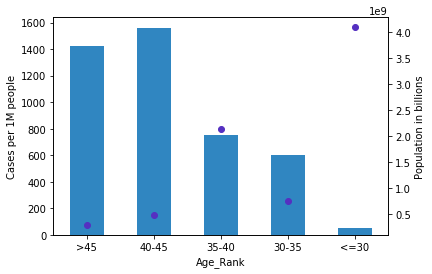

In [63]:
f = plt.figure()
ax = df_grouped_Age['Cases per 1M P'].plot.bar(rot=0,color='#3086c1')
ax2 = ax.twinx()

ax2.plot(ax.get_xticks(),
         df_grouped_Age['Population'].values,
         linestyle=' ',
         marker='o', color='#5530c1')

ax.set_ylabel('Cases per 1M people')
ax2.set_ylabel('Population in billions')


In [64]:
f.savefig('chart_01.png')#I like the pic and I save it

We can see that it is clear that the **target of the virus** is the **old people**

Lets plot rest of the vars

Text(0, 0.5, '%')

<Figure size 432x288 with 0 Axes>

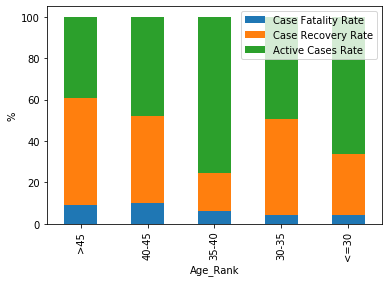

In [65]:
f = plt.figure()
df_grouped_Age[['Case Fatality Rate','Case Recovery Rate','Active Cases Rate']].plot(kind='bar', stacked=True)
plt.ylabel('%')


In [66]:
f.savefig('chart_02.png')#I like the pic and I save it


Chart Above is great to see how advance are the countries fighting with the **disease**, depending on how old are they



### Finally

I want to show some geopandas map, I think they are really self explanatory! 

In [67]:
# set the filepath and load
fp = 'World_Countries.shp'
#reading the file stored in variable fp
map_df = gpd.read_file(fp)
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
map_df.head()

,COUNTRY,geometry
0,Aruba (Netherlands),"POLYGON ((-69.88223 12.41111, -69.94695 12.436..."
1,Antigua and Barbuda,"MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ..."
2,Afghanistan,"POLYGON ((61.27656 35.60725, 61.29638 35.62853..."
3,Algeria,"POLYGON ((-5.15213 30.18047, -5.13917 30.19236..."
4,Azerbaijan,"MULTIPOLYGON (((46.54037 38.87559, 46.49554 38..."


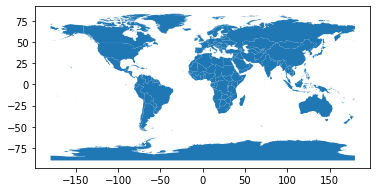

In [68]:
map_df.plot()

In [69]:
df = gpd.read_file(fp)

In [70]:
df.head()

,COUNTRY,geometry
0,Aruba (Netherlands),"POLYGON ((-69.88223 12.41111, -69.94695 12.436..."
1,Antigua and Barbuda,"MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ..."
2,Afghanistan,"POLYGON ((61.27656 35.60725, 61.29638 35.62853..."
3,Algeria,"POLYGON ((-5.15213 30.18047, -5.13917 30.19236..."
4,Azerbaijan,"MULTIPOLYGON (((46.54037 38.87559, 46.49554 38..."


In [71]:
data_for_map = df.rename(index=str, columns={'COUNTRY': 'COUNTRY', 'geometry': 'geometry'})

To be able to plot my df_plot with the shp file I have downloaded, I need to correct the spell.

I have created the dictionary bellow:
 

In [72]:
phd_dict = {'Afghanistan':'Afghanistan',
'Albania':'Albania',
'Algeria':'Algeria',
'American Samoa':'American Samoa (US)',
'Andorra':'Andorra',
'Angola':'Angola',
'Anguilla':'Anguilla (UK)',
'Antigua and Barbuda':'Antigua and Barbuda',
'Argentina':'Argentina',
'Armenia':'Armenia',
'Aruba':'Aruba (Netherlands)',
'Australia':'Australia',
'Austria':'Austria',
'Azerbaijan':'Azerbaijan',
'Bahamas':'Bahamas',
'Bahrain':'Bahrain',
'Bangladesh':'Bangladesh',
'Barbados':'Barbados',
'Belarus':'Belarus',
'Belgium':'Belgium',
'Belize':'Belize',
'Benin':'Benin',
'Bermuda':'Bermuda (UK)',
'Bhutan':'Bhutan',
'Bolivia':'Bolivia',
'Bosnia and Herzegovina':'Bosnia and Herzegovina',
'Botswana':'Botswana',
'Brazil':'Brazil',
'British Virgin Islands':'British Virgin Islands(UK)',
'Brunei':'Brunei',
'Bulgaria':'Bulgaria',
'Burkina Faso':'Burkina Faso',
'Burundi':'Burundi',
'Cabo Verde':'Cape Verde',
'Cambodia':'Cambodia',
'Cameroon':'Cameroon',
'Canada':'Canada',
'Caribbean Netherlands':'Netherlands',
'Cayman Islands':'Cayman Islands (UK)',
'Central African Republic':'Central African Republic',
'Chad':'Chad',
'Channel Islands':'Channel Islands',
'Chile':'Chile',
'China':'China',
'Colombia':'Colombia',
'Comoros':'Comoros',
'Congo':'Congo',
'Cook Islands':'Cook Islands (New Zealand)',
'Costa Rica':'Costa Rica',
"Côte d'Ivoire":'Ivory Coast',
'Croatia':'Croatia',
'Cuba':'Cuba',
'Curaçao':'Curacao (Netherlands)',
'Cyprus':'Cyprus',
'Czech Republic (Czechia)':'Czech Republic',
'Denmark':'Denmark',
'Djibouti':'Djibouti',
'Dominica':'Dominica',
'Dominican Republic':'Dominican Republic',
'DR Congo':'Democratic Republic of the Congo',
'Ecuador':'Ecuador',
'Egypt':'Egypt',
'El Salvador':'El Salvador',
'Equatorial Guinea':'Equatorial Guinea',
'Eritrea':'Eritrea',
'Estonia':'Estonia',
'Eswatini':'Swaziland',
'Ethiopia':'Ethiopia',
'Faeroe Islands':'Faroe Islands (Denmark)',
'Falkland Islands':'Falkland Islands (UK)',
'Fiji':'Fiji',
'Finland':'Finland',
'France':'France',
'French Guiana':'French Guiana (France)',
'French Polynesia':'French Polynesia (France)',
'Gabon':'Gabon',
'Gambia':'Gambia',
'Georgia':'Georgia',
'Germany':'Germany',
'Ghana':'Ghana',
'Gibraltar':'Gibraltar (UK)',
'Greece':'Greece',
'Greenland':'Greenland (Denmark)',
'Grenada':'Grenada',
'Guadeloupe':'Guadeloupe (France)',
'Guam':'Guam (US)',
'Guatemala':'Guatemala',
'Guinea':'Guinea',
'Guinea-Bissau':'Guinea-Bissau',
'Guyana':'Guyana',
'Haiti':'Haiti',
'Holy See':'Holy See',
'Honduras':'Honduras',
'Hong Kong':'Hong Kong',
'Hungary':'Hungary',
'Iceland':'Iceland',
'India':'India',
'Indonesia':'Indonesia',
'Iran':'Iran',
'Iraq':'Iraq',
'Ireland':'Ireland',
'Isle of Man':'Isle of Man (UK)',
'Israel':'Israel',
'Italy':'Italy',
'Jamaica':'Jamaica',
'Japan':'Japan',
'Jordan':'Jordan',
'Kazakhstan':'Kazakhstan',
'Kenya':'Kenya',
'Kiribati':'Kiribati',
'Kuwait':'Kuwait',
'Kyrgyzstan':'Kyrgyzstan',
'Laos':'Laos',
'Latvia':'Latvia',
'Lebanon':'Lebanon',
'Lesotho':'Lesotho',
'Liberia':'Liberia',
'Libya':'Libya',
'Liechtenstein':'Liechtenstein',
'Lithuania':'Lithuania',
'Luxembourg':'Luxembourg',
'Macao':'Macao',
'Madagascar':'Madagascar',
'Malawi':'Malawi',
'Malaysia':'Malaysia',
'Maldives':'Maldives',
'Mali':'Mali',
'Malta':'Malta',
'Marshall Islands':'Marshall Islands',
'Martinique':'Martinique (France)',
'Mauritania':'Mauritania',
'Mauritius':'Mauritius',
'Mayotte':'Mayotte (France)',
'Mexico':'Mexico',
'Micronesia':'Federated States of Micronesia',
'Moldova':'Moldova',
'Monaco':'Monaco',
'Mongolia':'Mongolia',
'Montenegro':'Montenegro',
'Montserrat':'Montserrat',
'Morocco':'Morocco',
'Mozambique':'Mozambique',
'Myanmar':'Myanmar',
'Namibia':'Namibia',
'Nauru':'Nauru',
'Nepal':'Nepal',
'Netherlands':'Netherlands',
'New Caledonia':'New Caledonia (France)',
'New Zealand':'New Zealand',
'Nicaragua':'Nicaragua',
'Niger':'Niger',
'Nigeria':'Nigeria',
'Niue':'Niue (New Zealand)',
'North Korea':'North Korea',
'North Macedonia':'Macedonia',
'Northern Mariana Islands':'Northern Mariana Islands (US)',
'Norway':'Norway',
'Oman':'Oman',
'Pakistan':'Pakistan',
'Palau':'Palau (US)',
'Panama':'Panama',
'Papua New Guinea':'Papua New Guinea',
'Paraguay':'Paraguay',
'Peru':'Peru',
'Philippines':'Philippines',
'Poland':'Poland',
'Portugal':'Portugal',
'Puerto Rico':'Puerto Rico (US)',
'Qatar':'Qatar',
'Réunion':'Reunion (France)',
'Romania':'Romania',
'Russia':'Russia',
'Rwanda':'Rwanda',
'Saint Barthelemy':'Saint Barthelemy',
'Saint Helena':'St. Helena (UK)',
'Saint Kitts & Nevis':'St. Kitts and Nevis',
'Saint Lucia':'St. Lucia',
'Saint Martin':'Saint Martin',
'Saint Pierre & Miquelon':'St. Pierre and Miquelon (France)',
'Samoa':'Western Samoa',
'San Marino':'San Marino',
'Sao Tome & Principe':'Sao Tome and Principe',
'Saudi Arabia':'Saudi Arabia',
'Senegal':'Senegal',
'Serbia':'Serbia',
'Seychelles':'Seychelles',
'Sierra Leone':'Sierra Leone',
'Singapore':'Singapore',
'Sint Maarten':'Sint Maarten',
'Slovakia':'Slovakia',
'Slovenia':'Slovenia',
'Solomon Islands':'Solomon Islands',
'Somalia':'Somalia',
'South Africa':'South Africa',
'South Korea':'South Korea',
'South Sudan':'South Sudan',
'Spain':'Spain',
'Sri Lanka':'Sri Lanka',
'St. Vincent & Grenadines':'St. Vincent and the Grenadines',
'State of Palestine':'Palestine',
'Sudan':'Sudan',
'Suriname':'Suriname',
'Sweden':'Sweden',
'Switzerland':'Switzerland',
'Syria':'Syria',
'Taiwan':'Taiwan',
'Tajikistan':'Tajikistan',
'Tanzania':'Tanzania',
'Thailand':'Thailand',
'Timor-Leste':'East Timor',
'Togo':'Togo',
'Tokelau':'Tokelau (New Zealand)',
'Tonga':'Tonga',
'Trinidad and Tobago':'Trinidad and Tobago',
'Tunisia':'Tunisia',
'Turkey':'Turkey',
'Turkmenistan':'Turkmenistan',
'Turks and Caicos':'Turks and Caicos Islands (UK)',
'Tuvalu':'Tuvalu',
'U.S. Virgin Islands':'American Virgin Islands (US)',
'Uganda':'Uganda',
'Ukraine':'Ukraine',
'United Arab Emirates':'United Arab Emirates',
'United Kingdom':'United Kingdom',
'United States':'United States',
'Uruguay':'Uruguay',
'Uzbekistan':'Uzbekistan',
'Vanuatu':'Vanuatu',
'Venezuela':'Venezuela',
'Vietnam':'Vietnam',
'Wallis & Futuna':'Wallis and Futuna (France)',
'Western Sahara':'Western Sahara',
'Yemen':'Yemen',
'Zambia':'Zambia',
'Zimbabwe':'Zimbabwe'}

In [73]:
df_plot['Country_PHD']= df_plot['Country']
df_plot['Country_PHD'].replace({'Country': phd_dict},  inplace = True)

In [74]:
df_plot.head()

,Country,Population,People_per_sqKm,Migrants,Avg_Age,Urban_Pop_perc,Free_healthcare,Total_Cases,Total_Deaths,Total_Recovered,Total_Tests,Age_Rank,Country_PHD
0,China,1439323776,153,-348399.0,38.0,0.61,1.0,82875.0,4633.0,77685.0,NaN,35-40,China
1,India,1380004385,464,-532687.0,28.0,0.35,0.0,37776.0,1223.0,10007.0,976363.0,<=30,India
2,United States,331002651,36,954806.0,38.0,0.83,0.0,1142775.0,66621.0,162107.0,6802653.0,35-40,United States
3,Indonesia,273523615,151,-98955.0,30.0,0.56,0.0,10843.0,831.0,1665.0,107943.0,<=30,Indonesia
4,Pakistan,220892340,287,-233379.0,23.0,0.35,1.0,18770.0,432.0,4753.0,193859.0,<=30,Pakistan


In [75]:
df_geo = pd.DataFrame()
df_geo = rate_df(df_plot)
df_geo.head()

,Country,Population,People_per_sqKm,Migrants,Avg_Age,Urban_Pop_perc,Free_healthcare,Total_Cases,Total_Deaths,Total_Recovered,...,Age_Rank,Country_PHD,Cases per 1M P,Tests per 1M P,Deaths per 1M P,Recovered per 1M P,Positives Rate,Case Fatality Rate,Case Recovery Rate,Active Cases Rate
0,China,1439323776,153,-348399.0,38.0,0.61,1.0,82875.0,4633.0,77685.0,...,35-40,China,57.579122,NaN,3.218873,53.973263,NaN,5.590347,93.737557,0.672097
1,India,1380004385,464,-532687.0,28.0,0.35,0.0,37776.0,1223.0,10007.0,...,<=30,India,27.373826,707.507172,0.886229,7.251426,3.869053,3.237505,26.490364,70.272130
2,United States,331002651,36,954806.0,38.0,0.83,0.0,1142775.0,66621.0,162107.0,...,35-40,United States,3452.464796,20551.657153,201.270291,489.745322,16.798961,5.829757,14.185382,79.984861
3,Indonesia,273523615,151,-98955.0,30.0,0.56,0.0,10843.0,831.0,1665.0,...,<=30,Indonesia,39.641915,394.638686,3.038129,6.087226,10.045116,7.663931,15.355529,76.980540
4,Pakistan,220892340,287,-233379.0,23.0,0.35,1.0,18770.0,432.0,4753.0,...,<=30,Pakistan,84.973521,877.617576,1.955704,21.517269,9.682295,2.301545,25.322323,72.376132


In [76]:
merged = map_df.set_index('COUNTRY').join(df_geo.set_index('Country_PHD'))#joining the dataframes

In [77]:
merged.dtypes

geometry              geometry
Country                 object
Population             float64
People_per_sqKm        float64
Migrants               float64
Avg_Age                float64
Urban_Pop_perc         float64
Free_healthcare        float64
Total_Cases            float64
Total_Deaths           float64
Total_Recovered        float64
Total_Tests            float64
Age_Rank                object
Cases per 1M P         float64
Tests per 1M P         float64
Deaths per 1M P        float64
Recovered per 1M P     float64
Positives Rate         float64
Case Fatality Rate     float64
Case Recovery Rate     float64
Active Cases Rate      float64
dtype: object

In [78]:
def geo_plot(df, column_rep, color_map='BuGn', legend=False):
    """function to plot a worldmap
    INPUT: 
    Dataframe
    column to show
    color
    show the legend?
    OUTPUT the fig and axis"""
    
    fig, ax = plt.subplots(1, figsize=(10, 6))
    ax.axis('off')
    variable = column_rep# set the range for the choropleth
    df.plot(column=variable, cmap=color_map, linewidth=0.8, ax=ax, edgecolor='0.8', legend=legend)
    return fig, ax 

def save_pic(fig, ax, title,source,color_map='BuGn'):
    """function to save the map
    INPUT: 
    previous fix and axis
    title of the chart
    source 
    color
    OUTPUT you save the picture"""
    vmin, vmax = 120, 220# create figure and axes for Matplotlib
    ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})# create an annotation for the data source
    ax.annotate('Source: {}'.format(source),xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
    sm = plt.cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(vmin=vmin, vmax=vmax))# empty array for the data range
    sm._A = []# add the colorbar to the figure
    return fig.savefig('map_export_{}.png'.format(title), dpi=300)
    

I will use insight below to show th countries with free healtcare policies

C:\Users\cvila\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


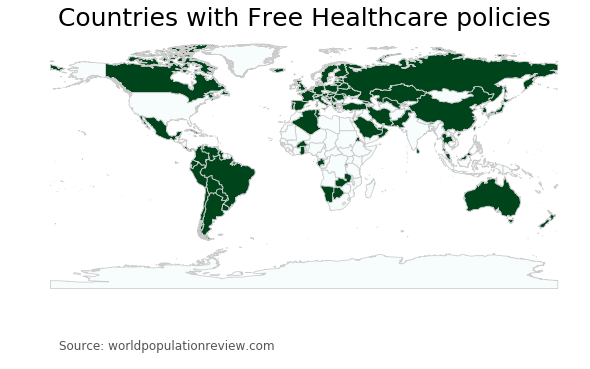

In [79]:
fig, ax = geo_plot(merged,'Free_healthcare')
save_fhplot = save_pic(fig, ax, 'Countries with Free Healthcare policies','worldpopulationreview.com')

We can see that Spain is terribly suffering the worst consequences of the virus

C:\Users\cvila\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


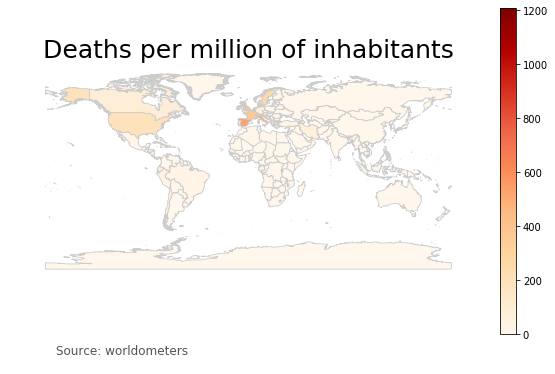

In [80]:
fig, ax = geo_plot(merged,'Deaths per 1M P', 'OrRd', True)
save_fhplot = save_pic(fig, ax, 'Deaths per million of inhabitants','worldometers','OrRd')



Wr can see in yellow the countries in a starting phase of the Virus pandemic

C:\Users\cvila\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


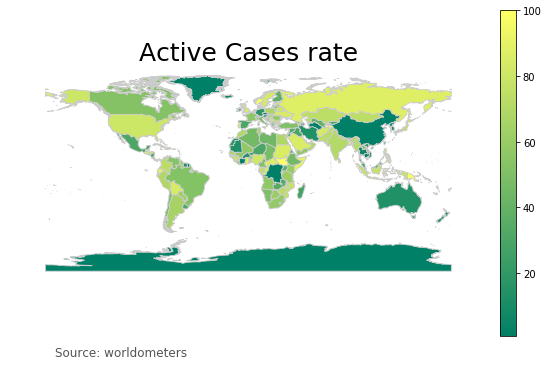

In [81]:
fig, ax = geo_plot(merged,'Active Cases Rate', 'summer', True)
save_fhplot = save_pic(fig, ax, 'Active Cases rate','worldometers','summer')



This picture is also self explanatory

C:\Users\cvila\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


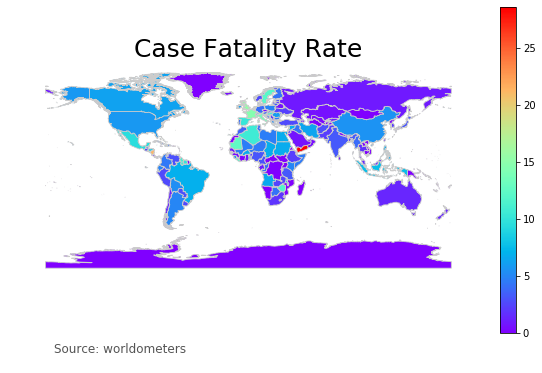

In [82]:
fig, ax = geo_plot(merged,'Case Fatality Rate', 'rainbow', True)
save_fhplot = save_pic(fig, ax, 'Case Fatality Rate','worldometers','rainbow')

There are many countries in violet colors, that they ar not providing any information about the performed test. THis map does not show much...

C:\Users\cvila\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


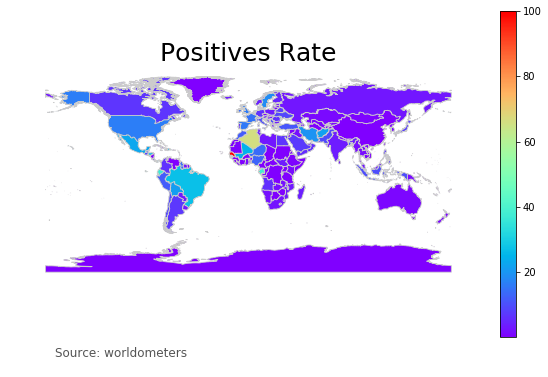

In [83]:
fig, ax = geo_plot(merged,'Positives Rate', 'rainbow', True)
save_fhplot = save_pic(fig, ax, 'Positives Rate','worldometers','rainbow')




I hope you have enjoyed discovering the information behind the COVID-19 data.
Bye!